In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import time

Available classic environments: ['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5']

Running MCTS on CartPole...
Episode 1, Step 10, Reward 10.0
Episode 1 finished with reward 10.0
Episode 2, Step 10, Reward 10.0
Episode 2 finished with reward 11.0

Running random agent on CartPole...
Random agent - Episode 1 finished with reward 22.0


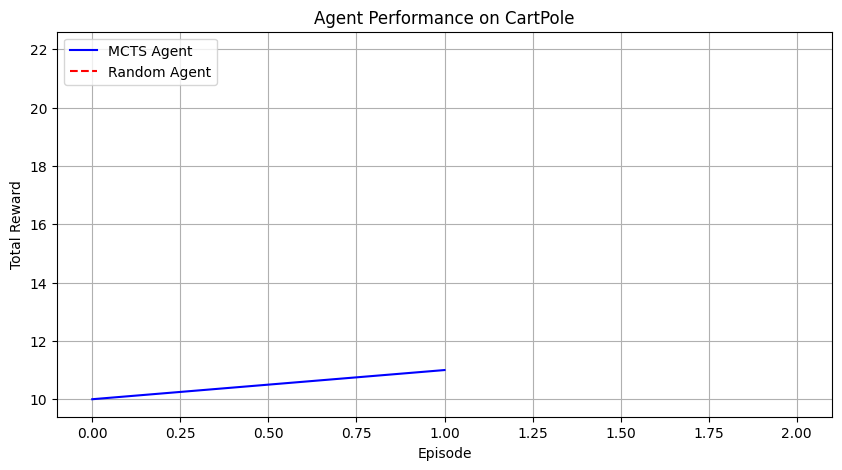


Average MCTS reward: 10.5
Average random reward: 22.0


In [2]:
class MCTSNode:
    def __init__(self, state, done=False):
        self.state = state
        self.visits = 0
        self.value = 0.0
        self.children = {}  # action -> MCTSNode
        self.done = done

    def is_fully_expanded(self, action_space):
        if hasattr(action_space, 'n'):
            return len(self.children) == action_space.n
        else:
            return len(self.children) >= 5

    def best_child(self, exploration_weight=1.0):
        if not self.children:
            return None

        def ucb1(child):
            exploitation = child.value / child.visits if child.visits > 0 else 0
            exploration = exploration_weight * np.sqrt(np.log(self.visits) / child.visits) if child.visits > 0 else float('inf')
            return exploitation + exploration

        return max(self.children.items(), key=lambda x: ucb1(x[1]))

    def select_unexplored_action(self, action_space):
        if hasattr(action_space, 'n'):
            for action in range(action_space.n):
                if action not in self.children:
                    return action
        else:
            while True:
                action = action_space.sample()
                if isinstance(action, np.ndarray):
                    action = tuple(action)
                if action not in self.children:
                    return action
        return None

class SimpleMCTS:
    def __init__(self, env, simulation_steps=10, exploration_weight=1.0):
        self.env = env
        self.simulation_steps = simulation_steps
        self.exploration_weight = exploration_weight

    def search(self, state, n_simulations=10):
        if hasattr(self.env.action_space, 'n'):
            action_space = range(self.env.action_space.n)
        else:
            action_space = [self.env.action_space.sample() for _ in range(5)]

        best_action = None
        best_value = float('-inf')

        for action in action_space:
            total_reward = 0

            for _ in range(n_simulations):
                sim_env = gym.make(self.env.unwrapped.spec.id)
                sim_env.reset()

                if hasattr(state, 'shape') and len(state.shape) == 1:
                    sim_state, _ = sim_env.reset()

                sim_state, reward, terminated, truncated, _ = sim_env.step(action)
                done = terminated or truncated
                sim_reward = reward

                for _ in range(self.simulation_steps):
                    if done:
                        break
                    random_action = sim_env.action_space.sample()
                    sim_state, reward, terminated, truncated, _ = sim_env.step(random_action)
                    done = terminated or truncated
                    sim_reward += reward

                sim_env.close()
                total_reward += sim_reward

            avg_reward = total_reward / n_simulations

            if avg_reward > best_value:
                best_value = avg_reward
                best_action = action

        return best_action

def discretize_state(state, bins=(10, 10, 10, 10)):
    if isinstance(state, np.ndarray) and state.shape == (4,):
        state_bounds = [
            [-2.4, 2.4],
            [-3.0, 3.0],
            [-0.3, 0.3],
            [-3.0, 3.0]
        ]
        discrete_state = []
        for s, bounds, b in zip(state, state_bounds, bins):
            s = max(bounds[0], min(s, bounds[1]))
            idx = int((s - bounds[0]) / (bounds[1] - bounds[0]) * b)
            idx = max(0, min(idx, b - 1))
            discrete_state.append(idx)
        return tuple(discrete_state)
    return state

def run_mcts_agent(env_name='CartPole-v1', n_episodes=3, render=True):
    env = gym.make(env_name, render_mode='human' if render else None)
    rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        state_d = discretize_state(state)
        episode_reward = 0
        done = False
        step = 0
        agent = SimpleMCTS(env, simulation_steps=10, exploration_weight=1.0)

        while not done and step < 500:
            action = agent.search(state_d, n_simulations=5)
            state, reward, terminated, truncated, _ = env.step(action)
            state_d = discretize_state(state)
            done = terminated or truncated
            episode_reward += reward
            step += 1
            if step % 10 == 0:
                print(f"Episode {episode+1}, Step {step}, Reward {episode_reward}")
        rewards.append(episode_reward)
        print(f"Episode {episode+1} finished with reward {episode_reward}")
    env.close()
    return rewards

def run_random_agent(env_name='CartPole-v1', n_episodes=3, render=True):
    env = gym.make(env_name, render_mode='human' if render else None)
    rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        step = 0
        while not done and step < 500:
            action = env.action_space.sample()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            step += 1
            if step % 50 == 0:
                print(f"Random agent - Episode {episode+1}, Step {step}, Reward {episode_reward}")
        rewards.append(episode_reward)
        print(f"Random agent - Episode {episode+1} finished with reward {episode_reward}")
    env.close()
    return rewards

# Main execution
from gymnasium.envs.registration import registry

classic_envs = [env_id for env_id in registry.keys() if 'CartPole' in env_id or 'Pendulum' in env_id or 'MountainCar' in env_id]
print(f"Available classic environments: {classic_envs}")

print("\nRunning MCTS on CartPole...")
mcts_rewards = run_mcts_agent(env_name='CartPole-v1', n_episodes=2, render=True)

print("\nRunning random agent on CartPole...")
random_rewards = run_random_agent(env_name='CartPole-v1', n_episodes=1, render=True)

plt.figure(figsize=(10, 5))
plt.plot(mcts_rewards, 'b-', label='MCTS Agent')
plt.plot(range(len(mcts_rewards), len(mcts_rewards) + len(random_rewards)), random_rewards, 'r--', label='Random Agent')
plt.title('Agent Performance on CartPole')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

print("\nAverage MCTS reward:", np.mean(mcts_rewards))
print("Average random reward:", np.mean(random_rewards))
